# 5.1 Reduction of VHE gamma-ray data

In this notebook, we will perform the **data reduction**, that is, we will obtain from our event list and instrument response function (the content of the DL3 files), a binned information that can be used to extract a scientific result (e.g. a spectrum or a light curve). We will reduce data from the MAGIC and H.E.S.S. telescopes. For the process of data reduction we will use [Gammapy](https://gammapy.org/). 

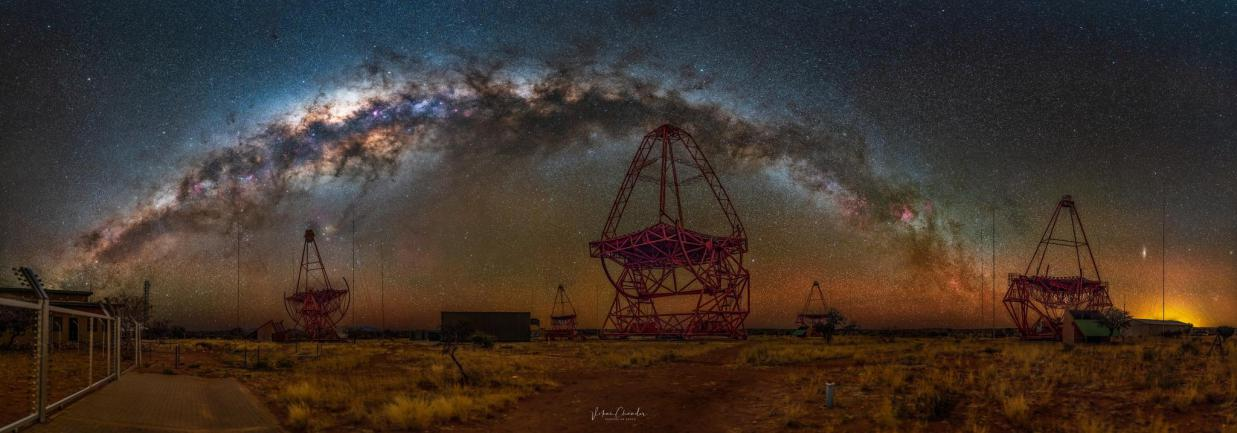

In [1]:
from IPython.display import Image

Image("../figures/hess.jpg", width=1000)

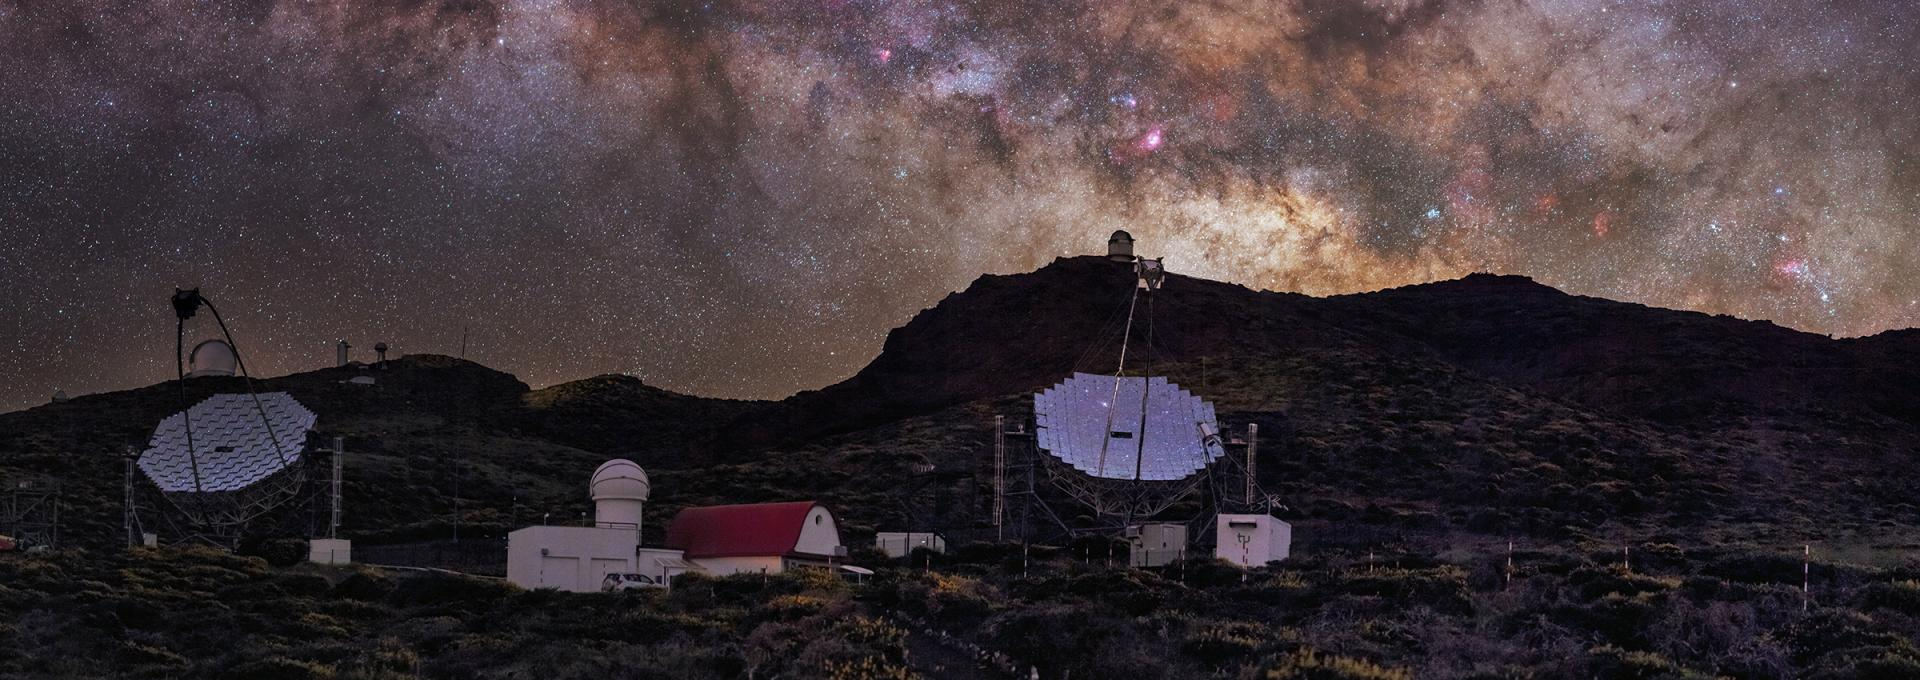

In [2]:
Image("../figures/magic.jpeg", width=1000)

In [3]:
# basic dependencies
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import PointSkyRegion, CircleSkyRegion
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

# Gammapy dependencies
from gammapy.data import DataStore
from gammapy.maps import Map, MapAxis, RegionGeom
from gammapy.datasets import Datasets, SpectrumDataset
from gammapy.makers import (
    ReflectedRegionsFinder,
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    WobbleRegionsFinder,
)
from gammapy.visualization import plot_spectrum_datasets_off_regions

Gammapy support for parallelisation with ray is still a prototype and is not fully functional.


In [4]:
def create_fake_legend(ax):
    """Make a fake legend representing the ON and OFF regions"""
    on = Line2D(
        [0],
        [0],
        markeredgecolor="crimson",
        markerfacecolor="none",
        markeredgewidth=1.5,
        marker="o",
        markersize=14,
        ls="",
        label="on region",
    )
    off = Line2D(
        [0],
        [0],
        markeredgecolor="dodgerblue",
        markerfacecolor="none",
        markeredgewidth=1.5,
        marker="o",
        markersize=14,
        ls="",
        label="off regions",
    )
    pointing = Line2D(
        [0],
        [0],
        markeredgecolor="goldenrod",
        markerfacecolor="none",
        markeredgewidth=1.5,
        marker="+",
        markersize=14,
        ls="",
        label="pointing",
    )

    ax.legend(handles=[on, off, pointing], loc="lower left")

In [5]:
def plot_on_off_regions(observation):
    # let us make a countmap of the events in one of the observations
    region_finder = ReflectedRegionsFinder()

    counts = Map.create(skydir=observation.pointing_radec, binsz=0.06, width=4)
    # define wcs geom from the counts map
    wcs = counts.geom.wcs

    # fill the map and plot it
    counts.fill_events(observation.events)
    ax = counts.plot(cmap="viridis")

    # plot pointing
    pointing = PointSkyRegion(observation.pointing_radec)
    pointing.to_pixel(wcs).plot(ax=ax, color="goldenrod", marker="+", markersize=14)
    # plot ON region
    on_region.to_pixel(wcs).plot(ax=ax, edgecolor="crimson", linewidth=2)
    # plot OFF regions
    off_regions, wcs = region_finder.run(
        region=on_region, center=observation.pointing_radec
    )
    for off_region in off_regions:
        off_region_circle = CircleSkyRegion(
            center=off_region.center, radius=on_region_radius
        )
        off_region_circle.to_pixel(ax.wcs).plot(
            ax=ax, edgecolor="dodgerblue", linewidth=2
        )
    create_fake_legend(ax)
    plt.show()

## 5.1.1 H.E.S.S. data reduction

The `gammapy.DataStore` objects allows us to read all the DL3 files (i.e. all the observations) in a directory. Let us start with the H.E.S.S. data.

In [6]:
hess_datastore = DataStore.from_dir("../../gammapy-data/hess-dl3-dr1/")
hess_datastore.obs_table

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
20136,228.6125,-58.771667,320.56754,-0.8857012,38.512962,51.487038,195.73102,MSH15-52,228.6125,-59.271667,0.5,1682.0,1521.0269,0.9042966,101962602.0,101964284.0,2004-03-26,02:57:46.184,2004-03-26,03:25:48.184,4,"1,2,3,4",0,1.2132596,11243,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20137,228.6125,-59.771667,320.04724,-1.7397733,40.21616,49.78384,199.6482,MSH15-52,228.6125,-59.271667,0.5,902.0,819.2054,0.90821,101964441.0,101965343.0,2004-03-26,03:28:25.184,2004-03-26,03:43:27.184,4,"1,2,3,4",0,1.2139559,5693,MSH 15-52,msh1552,0.6156251,0.40738028,100.0
20151,228.6125,-58.771667,320.56754,-0.8857012,37.164658,52.835342,190.97171,custom,228.6125,-59.271667,0.5,1683.0,1530.479,0.9093755,102047232.0,102048915.0,2004-03-27,02:28:16.184,2004-03-27,02:56:19.184,4,"1,2,3,4",0,1.2214733,10722,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20275,187.27792,2.552389,289.7155,64.849686,36.18243,53.81757,49.144917,3C 273,187.27792,2.052389,0.5,1683.0,1525.8447,0.90662193,103665036.0,103666719.0,2004-04-14,19:51:40.184,2004-04-14,20:19:43.184,4,"1,2,3,4",0,1.121256,10646,Off data,offdata,--,0.33113113,100.0
20282,228.6125,-58.771667,320.56754,-0.8857012,37.13134,52.86866,169.21602,MSH 15-5-02,228.6125,-59.271667,0.5,1687.0,1543.3231,0.9148329,103678269.0,103679956.0,2004-04-14,23:32:13.184,2004-04-15,00:00:20.184,4,"1,2,3,4",0,1.1495326,11063,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20283,228.6125,-59.771667,320.04724,-1.7397733,36.221436,53.778564,175.77263,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1547.8253,0.9196823,103680087.0,103681770.0,2004-04-15,00:02:31.184,2004-04-15,00:30:34.184,4,"1,2,3,4",0,1.1512518,7628,MSH 15-52,msh1552,0.6156251,0.3801894,100.0
20301,228.6125,-58.771667,320.56754,-0.8857012,36.839905,53.160095,171.07347,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1534.0626,0.9115048,103764878.0,103766561.0,2004-04-15,23:35:42.184,2004-04-16,00:03:45.184,4,"1,2,3,4",0,1.1503073,11624,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20302,228.6125,-59.771667,320.04724,-1.7397733,36.11632,53.88368,177.10521,MSH 15-5-02,228.6125,-59.271667,0.5,1682.0,1535.3478,0.9128108,103766698.0,103768380.0,2004-04-16,00:06:02.184,2004-04-16,00:34:04.184,4,"1,2,3,4",0,1.1493496,11794,MSH 15-52,msh1552,0.6156251,0.3801894,100.0


This table gives us an overview of the conditions of the different observations. We are interested in Crab Nebula observations, let us select the observation IDs corresponding to them:

In [7]:
crab_obs_mask = hess_datastore.obs_table["TARGET_NAME"] == "Crab"
obs_ids = hess_datastore.obs_table["OBS_ID"][crab_obs_mask]
print(obs_ids)

OBS_ID
------
 23523
 23526
 23559
 23592


In [8]:
# let us get the `gammapy.Observation`s, the object representing the individual DL3 files
observations = hess_datastore.get_observations(obs_ids)
print(observations)

Observations
Number of observations: 4
Observation

	obs id            : 23523 
 	tstart            : 53343.92
	tstop             : 53343.94
	duration          : 1687.00 s
	pointing (icrs)   : 83.6 deg, 21.5 deg

	deadtime fraction : 6.2%
Observation

	obs id            : 23526 
 	tstart            : 53343.95
	tstop             : 53343.97
	duration          : 1683.00 s
	pointing (icrs)   : 83.6 deg, 22.5 deg

	deadtime fraction : 6.6%
Observation

	obs id            : 23559 
 	tstart            : 53345.96
	tstop             : 53345.98
	duration          : 1686.00 s
	pointing (icrs)   : 85.3 deg, 22.0 deg

	deadtime fraction : 6.4%
Observation

	obs id            : 23592 
 	tstart            : 53347.91
	tstop             : 53347.93
	duration          : 1686.00 s
	pointing (icrs)   : 82.0 deg, 22.0 deg

	deadtime fraction : 6.2%



### Content of the DL3 data

As already said, the `Observation` is the `Gammapy` class representing the DL3 files.   
A DL3 file contains a list of events and the Instrument Response Function (IRF).

In [9]:
observations[0].events.table

EVENT_ID,TIME,RA,DEC,ENERGY
,s,deg,deg,TeV
int64,float64,float32,float32,float32
5407363825684,123890826.66805482,84.97964,23.89347,10.352011
5407363825695,123890826.69749284,84.54751,21.004095,4.0246882
5407363825831,123890827.23673964,85.39696,19.41868,2.2048872
5407363825970,123890827.79615426,81.93147,20.79867,0.69548655
5407363826067,123890828.26131463,85.98302,21.053099,0.86911184
5407363826095,123890828.41393518,86.97305,21.837437,4.1240892
5407363826128,123890828.52555823,83.40073,19.771587,1.6680022
5407363826168,123890828.6829524,82.25036,19.22003,4.7649446


To visualise a histogrammed version of the event quantities and the IRF components, we use the `.peek()` function.

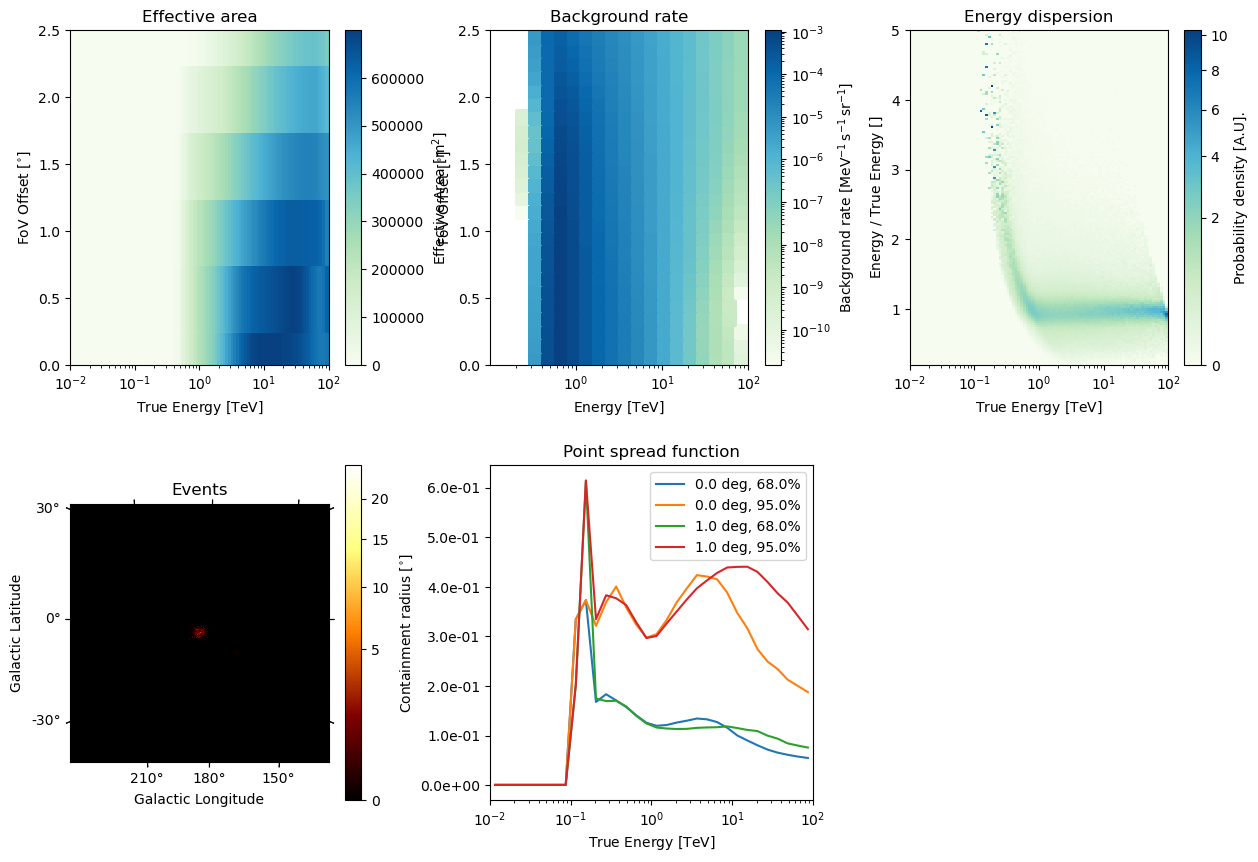

In [10]:
observations[0].peek()

### Data reduction
We pass now from **observations** to **datasets**. While observations contain all the information of the events and the complete IRF dependency (from energy and offset) we need a more reduced information to perform a likelihood analysis.

In a so-called point-like analysis, we neglect the morphology of the source and focus on modelling the number of signal and background counts vs energy. Extracting this information from the observation is done by the `SpectrumDataset`.

In [11]:
# define the on region
target_position = SkyCoord(ra=83.63333, dec=22.01444, unit="deg", frame="icrs")
on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

In [12]:
energy_axis = MapAxis.from_energy_bounds(
    0.1, 40, nbin=10, per_decade=True, unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100, nbin=20, per_decade=True, unit="TeV", name="energy_true"
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [13]:
datasets = Datasets()

for obs_id, observation in zip(obs_ids, observations):
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

print(datasets)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 23523
  Instrument : HESS
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 23526
  Instrument : HESS
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : 23559
  Instrument : HESS
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : 23592
  Instrument : HESS
  Models     : 




What have we done? We have reduced the events in Let us use the `Observation`s to display it.

/var/folders/3j/5qfdl_zd5592prn9f_v4l_gw0000gp/T/ipykernel_41055/2980416987.py:5: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  counts = Map.create(skydir=observation.pointing_radec, binsz=0.06, width=4)
/Users/cosimo/software/mambaforge/envs/gammapy-dev/lib/python3.9/site-packages/astropy/utils/decorators.py:837: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/var/folders/3j/5qfdl_zd5592prn9f_v4l_gw0000gp/T/ipykernel_41055/2980416987.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing = PointSkyRegion(observation.pointing_radec)
/var/folders/3j/5qfdl_zd5592prn9f_v4l_gw0000gp/T/ipykernel_41055/2980416987.py:21: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  center=observation.pointing_radec


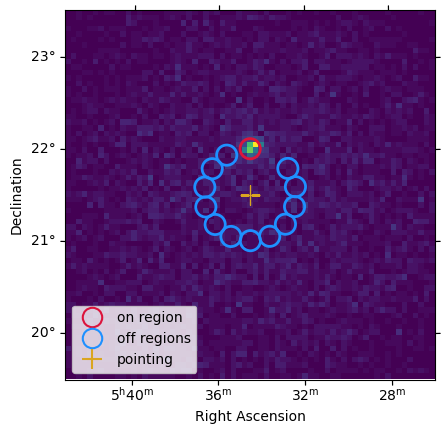

In [14]:
plot_on_off_regions(observations[0])

/var/folders/3j/5qfdl_zd5592prn9f_v4l_gw0000gp/T/ipykernel_41055/2980416987.py:5: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  counts = Map.create(skydir=observation.pointing_radec, binsz=0.06, width=4)
/Users/cosimo/software/mambaforge/envs/gammapy-dev/lib/python3.9/site-packages/astropy/utils/decorators.py:837: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/var/folders/3j/5qfdl_zd5592prn9f_v4l_gw0000gp/T/ipykernel_41055/2980416987.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing = PointSkyRegion(observation.pointing_radec)
/var/folders/3j/5qfdl_zd5592prn9f_v4l_gw0000gp/T/ipykernel_41055/2980416987.py:21: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  center=observation.pointing_radec


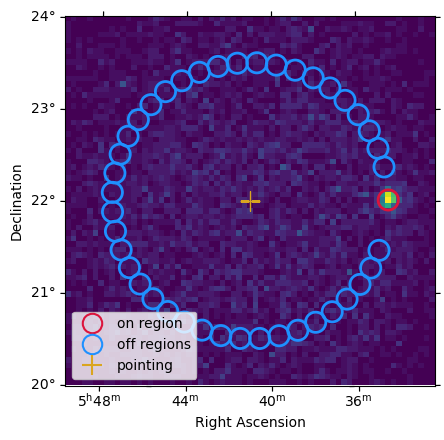

In [15]:
plot_on_off_regions(observations[2])

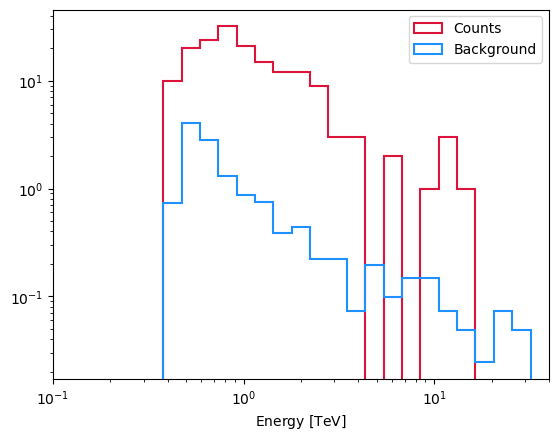

In [16]:
datasets[2].plot_counts(
    kwargs_counts={"color": "crimson", "lw": 1.5},
    kwargs_background={"color": "dodgerblue", "lw": 1.5},
)
plt.show()

In [17]:
results_dir = Path("results/spectra/hess")
results_dir.mkdir(exist_ok=True, parents=True)

for observation, dataset in zip(observations, datasets):
    dataset.write(results_dir / f"pha_obs_{observation.obs_id}.fits", overwrite=True)

## 5.1.2 MAGIC data reduction


The ON region is a `PointSkyRegion`, the size of this region will be taken from the `RAD_MAX` table.

We now need the true and estimated energy axis over which to compute the IRF. The IRF components we stored is interpolated, therefore for `Gammapy` they are functions of the offset and energy. We need their values in the same energy bins that we will use for the counts.

In [18]:
data_store = DataStore.from_dir("../../gammapy-data/magic/rad_max/data/")
observations = data_store.get_observations(required_irf="point-like")
print(observations)

Observations
Number of observations: 2
Observation

	obs id            : 5029747 
 	tstart            : 56569.18
	tstop             : 56569.19
	duration          : 1188.11 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 0.8%
Observation

	obs id            : 5029748 
 	tstart            : 56569.20
	tstop             : 56569.21
	duration          : 1183.80 s
	pointing (icrs)   : 83.3 deg, 21.8 deg

	deadtime fraction : 0.8%



'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.


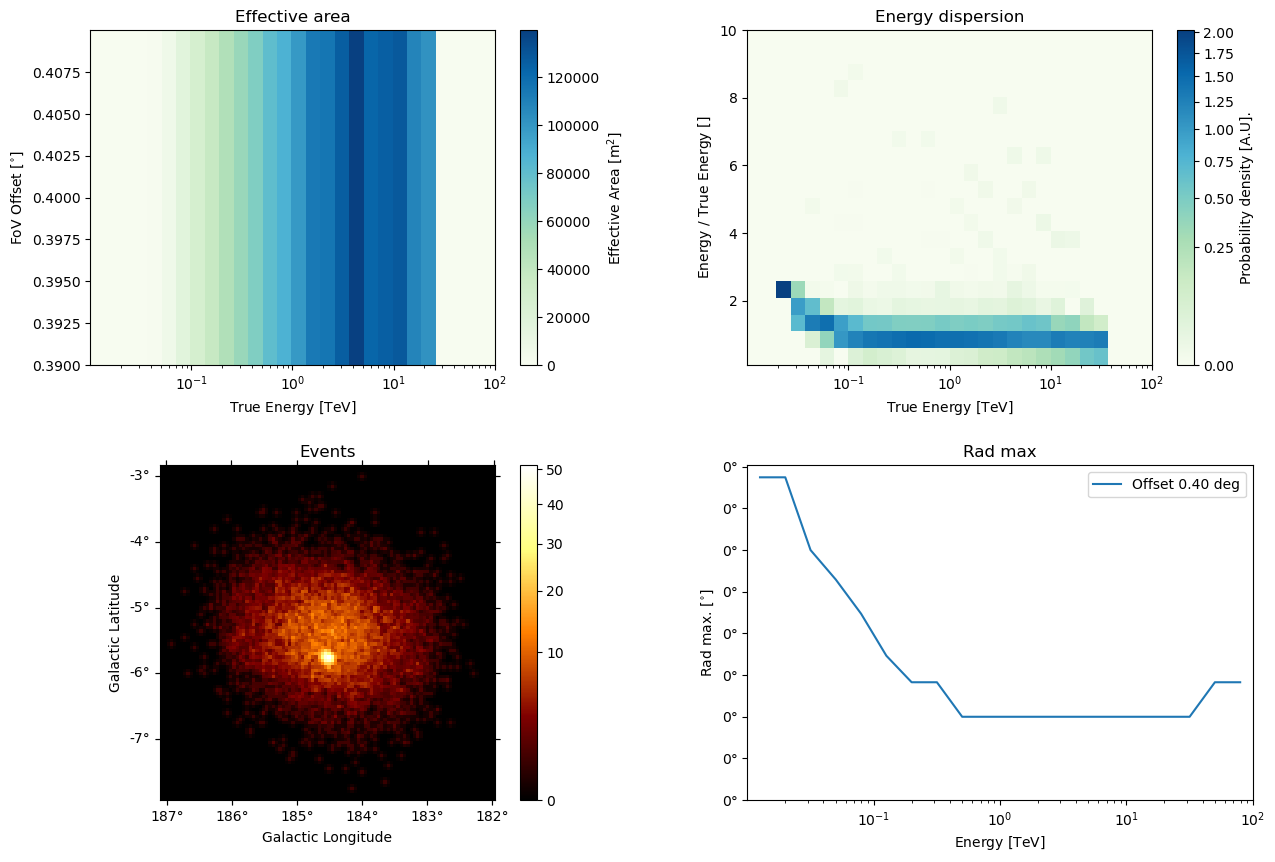

In [19]:
observations[0].peek()

In [20]:
# define the on region
target_position = SkyCoord(ra=83.63333, dec=22.01444, unit="deg", frame="icrs")
on_region = PointSkyRegion(target_position)

In [21]:
# true and estimated energy axes
energy_axis = MapAxis.from_energy_bounds(10, 1e5, nbin=20, unit="GeV", name="energy")
energy_axis_true = MapAxis.from_energy_bounds(
    10, 1e5, nbin=28, unit="GeV", name="energy_true"
)

# the geometry defines the array of ON counts
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

In [22]:
# the maker will actually fill the array of counts and compute the IRF
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"]
)

# we need a RegionsFinder to find the OFF regions
# and a BackgroundMaker to fill the array of the OFF counts
region_finder = WobbleRegionsFinder(n_off_regions=1)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

In [23]:
datasets = Datasets()

for observation in observations:
    # fill the ON counts array and compute the IRF at the observation offset
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(observation.obs_id)), observation
    )
    # fill the OFF counts
    dataset_on_off = bkg_maker.run(dataset, observation)
    datasets.append(dataset_on_off)

'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' 

Let us check now what the `Dataset`s we created contain

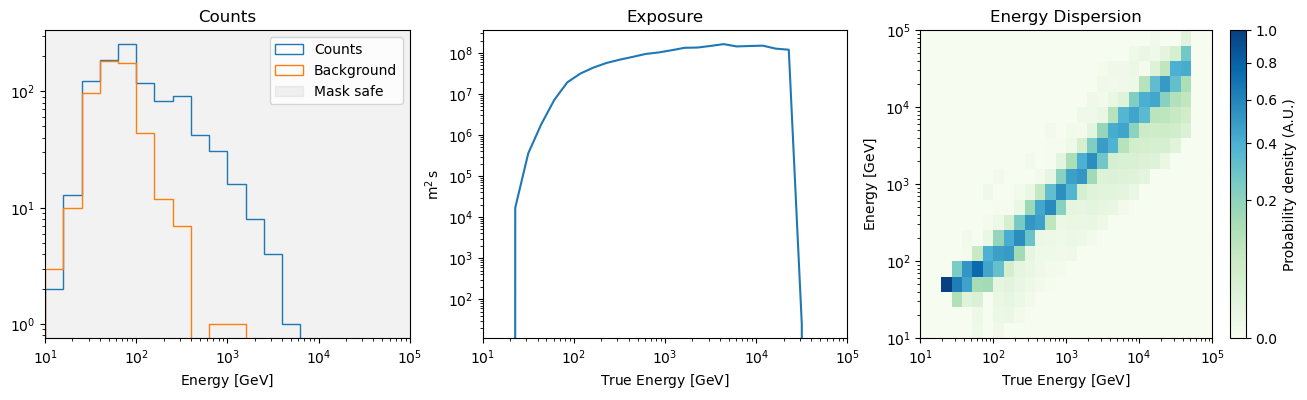

In [24]:
datasets[0].peek()

We will see in the next tutorial that this is all we need to fit the spectrum. Let us save to disk the reduced data, in the meanwhile.

In [25]:
results_dir = Path("results/spectra/magic")
results_dir.mkdir(exist_ok=True, parents=True)

for observation, dataset in zip(observations, datasets):
    dataset.write(results_dir / f"pha_obs_{observation.obs_id}.fits", overwrite=True)